# Middle Income Renters and Homeowners in California

Analysis to better understand the current economic state and composition of Middle Income Renters and Homeowners (80-120% of AMI) in California. 

The notebook is broken up into sections. Functions are kept within the notebook for ease of code review:

0. [Load and Clean ACS Household Data](#section0)

1. [Renter and Mortgage Holder Cost Burden Charts ](#section1)
    - Charts 3A and 3B, respectively, in the Missing Middle Brief 
2. [Load and Clean ACS Person Data](#section2)

3. [Share of Middle-Income Renters Paying More than 30% of Income in Rent, 2010 & 2019, by Race](#section3)
    - Chart 4 in Missing Middle Brief 
 
Data from:
- 2019 and 2010 PUMS 
- HCD AMI Limits https://www.hcd.ca.gov/grants-funding/income-limits/state-and-federal-income-limits/docs/income-limits-2019.pdf
- Geography Crosswalks from MCDC http://mcdc.missouri.edu/applications/geocorr2018.html

In [104]:
import pandas as pd
import numpy as np
import warnings
import wquantiles as wq
from statistics import mean
import os
import altair as alt
from urllib.request import urlopen
import zipfile

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

#NOTE only need below change to altair rendering to have static altair images render on github 
#b/c github scrubs javascript CAN REMOVE if running locally
#Also, if you do want this to work for some reason, need to have selenium/chromedriver installed 
alt.renderers.enable('altair_saver', fmts=['vega-lite', 'png'])

RendererRegistry.enable('altair_saver')

<div id="section0"></div>

# Load and Clean PUMS Data

In [105]:
def check_for_PUMS_download(filename,zip_location,zip_name):
    """
    inputs:
        filename (str) - name of csv downloaded from PUMS 
        zip_location (str) - location of zip file (can edit URL for year/version of data)
        zip_name (str) - name of the zip file downloaded from the zip location to open 
        
    here checking to see if 2019 1-year PUMS data is in the current directory, if not, downloading and unzipping 
    it to the current directory (can place is somewhere else by modifying filepath of zip_directory)
    """
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
        return df
    else:
        PUMS_url = zip_location
        zip_directory = os.getcwd() 
        url = urlopen(PUMS_url)
        output = open(zip_name, 'wb')           
        output.write(url.read())
        output.close()
        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall(zip_directory)
        df = pd.read_csv(filename)
    return df

df_2019 = check_for_PUMS_download('./psam_h06.csv',"https://www2.census.gov/programs-surveys/acs/data/pums/2019/1-Year/csv_hca.zip","./pums_2019.zip")
df_2010 = check_for_PUMS_download('./ss10hca.csv',"https://www2.census.gov/programs-surveys/acs/data/pums/2010/1-Year/csv_hca.zip",'./pums_2010.zip')

In [106]:
#rename columns and only keep subset (extra cols were for some exploratory analysis) 
def rename_cols(df):
    """
    inputs:
        df (dataframe): PUMS data
    Renames columns with more verbose names and returns subset of columns
    """
    df.rename(columns={"RT":"record_type",
                     "TYPE":"type",
                     "BLD":"units_in_structure",
                     "BDSP":"number_bedrooms",
                     "RNTP":"monthly_rent",
                     "MRGP":"first_mortgage",
                     "SMP":"second_mortgage",
                     "TEN":"tenure",
                     "VACS":"vacancy_status",
                     "VALP":"property_value",
                     "GRPIP":"gross_rent_pct_of_income",
                     "GRNTP":"gross_rent",
                     "SMOCP":"select_owner_cost",
                     "OCPIP":"select_owner_cost_pct_of_income",
                     "HINCP":"hh_income",
                     "NP":"ppl_in_hh",
                     "NRC":"num_relate_chldrn",
                     "NOC":"num_own_chldrn",
                     "WGTP":"weight",
                     "YBL": "year_built",
                     }, inplace=True)

    df = df[["SERIALNO","hh_income","first_mortgage","select_owner_cost","gross_rent_pct_of_income","select_owner_cost_pct_of_income","second_mortgage","ppl_in_hh",'PUMA',"gross_rent","monthly_rent","weight","year_built","tenure","property_value"]]
    return df 

df_2019 = rename_cols(df_2019)
df_2010 = rename_cols(df_2010)
#to calc ami ranges we need household income, safely drop (this drop 16382 records from 2010;24148 from 2019 )
df_2019 = df_2019.dropna(subset=["hh_income"])
df_2010 = df_2010.dropna(subset=["hh_income"])

### Crosswalk and Weighting 

In [107]:
#import and clean a PUMA to county crosswalk from mcdc for both 2010 and 2019 (need both b/c pumas change)
def import_clean_crosswalk(location,county_col,puma_col):
    """
    inputs:
        location (str): Location of crosswalk csv
        county_col (str): name of column with counties 
        puma_col (str): name of column with PUMAs
    Reads in and cleans up crosswalk files from geocorr, returning subset of columns
    """
    #PUMA - County Crosswalk URL generated from https://mcdc.missouri.edu/applications/geocorr2018.html with puma12 & county14
    crosswalk_county = pd.read_csv(location)
    crosswalk_county = crosswalk_county.iloc[1:]
    crosswalk_county[county_col] = crosswalk_county[county_col].str.replace(r' CA', '')
    crosswalk_county = crosswalk_county[[puma_col,county_col,"afact"]]
    crosswalk_county.rename(columns={puma_col:"PUMA",county_col:"County"},inplace=True)
    return crosswalk_county

#create PUMA county crosswalk for the seperate years 
crosswalk_county_2019 = import_clean_crosswalk("geocorr2018_2115904557.csv",'cntyname2',"puma12")
crosswalk_county_2010 = import_clean_crosswalk("geocorr_old_pumas.csv","cntyname","puma2k")

In [108]:
def crosswalk_weighting(df,crosswalk):
    """
    inputs:
        df (dataframe): PUMS data 
        crosswalk (dataframe): crosswalk of PUMAs to Counties with weights 
        puma_col (str): name of column with PUMAs
    Splits dataset between places with 1 to 1 PUMA matches to counties, do those matches, and then those 
    with many to 1 matches with weights, multiplies by the weights, and then concat
    """
    crosswalk.PUMA = crosswalk.PUMA.astype(str).str.zfill(5)
    crosswalk.afact = crosswalk.afact.astype(float)
    #clean merger
    clean_crosswalks = crosswalk[crosswalk.afact.astype(float)==1]
    clean_crosswalks_PUMAs = clean_crosswalks.PUMA.unique()
    df.PUMA = df.PUMA.astype(str).str.zfill(5)
    df_clean_merger = df[df.PUMA.isin(clean_crosswalks_PUMAs)]
    df_clean = pd.merge(df_clean_merger, clean_crosswalks, on='PUMA', how='left')
    df_clean = df_clean.drop_duplicates()
     
    #weighted crosswalks 
    weighted_crosswalks = crosswalk[crosswalk.afact <1]
    weighted_crosswalks = weighted_crosswalks[weighted_crosswalks.afact != 0]
    weighted_crosswalks_PUMA = weighted_crosswalks.PUMA.unique()
    df_weighted = df[df.PUMA.isin(weighted_crosswalks_PUMA)]

    df_weighted = df_weighted.merge(weighted_crosswalks, on='PUMA',how="left")
    df_weighted["weight"] = df_weighted["weight"] * df_weighted["afact"]
    df_weighted = df_weighted[df_weighted.weight != 0]
    
    full_data = pd.concat([df_clean,df_weighted])
    full_data = full_data.drop_duplicates()
    full_data['county_name'] = full_data.County + " County"
    return full_data

df_2019 = crosswalk_weighting(df_2019,crosswalk_county_2019)
df_2010 = crosswalk_weighting(df_2010,crosswalk_county_2010)

In [109]:
#merge on AMI bands for county/year/household size combos
AMI=pd.read_csv("CA_AMI_wide.csv")#csv with HCD AMI Bands from HCD website 
AMI=AMI[AMI.year.isin([2010,2019])]
#reshape data 
amelti = AMI.melt(id_vars=['county_name',  'year'])
amelti['hh'] = amelti.variable.apply(lambda x: x.split('_')[0])
amelti['idk'] = amelti.variable.apply(lambda x: x.split('_')[1])
amelti = amelti.pivot_table(index=['county_name','year', 'hh'], columns=['idk'], values='value').reset_index()
amelti['ppl_in_hh'] = amelti.hh.apply(lambda x: int(x.replace('hh','')))
#adjust for a weird quick in AMI calculations where sometimes 80% AMI is higher than 100% AMI
amelti["LI80"] = np.where(amelti["LI80"] > amelti["MED100"],amelti["MED100"],amelti["LI80"])

In [110]:
#merge 2010 and 2019 data 
df_2010['year'] = 2010
df_2019['year'] = 2019
df = df_2010.append(df_2019, ignore_index=True)

### Calculate weighted percentage of renters and homeowners that are cost burdened 

In [111]:
def calc_burdern(df,variable,final_variable_name,mid=False):
    """
    Inputs:
        df (dataframe) - PUMS data
        variable (str) - name of PUMS variable to check for financial burden
                         in this likely gross_rent or select_owner_cost
        final_variable_name (str) - name of new column for type of burden 
        mid (bool) - True if you want to filter for just middle income, false if want all AMI Bands 
    Calculate percent burdended (>30 of income to rent or home ownership costs) of each AMI Band, filtering for just 
    middle income in mid=True
    """
    df = df.dropna(subset=["hh_income",variable])
    df = df[df['hh_income'] >=0] #drop negative hh income  
    df = df[(df.gross_rent != ' ')] 
    df = pd.merge(df, amelti, on=[ 'year', 'ppl_in_hh'], how='left')
    df['elow_income'] = np.where((df["hh_income"] < df["ELI30"]), 1, 0)
    df['vlow_income'] = np.where((df["hh_income"] >= df["ELI30"])&(df["hh_income"] < df["VLI50"]), 1, 0)
    df['low_income'] = np.where((df["hh_income"] >= df["VLI50"])&(df["hh_income"] < df["LI80"]), 1, 0)
    df['middle_income'] = np.where((df["hh_income"] >= df["LI80"])&(df["hh_income"] < df["MOD120"]), 1, 0)
    df['high_income'] = np.where((df["hh_income"] >= df["MOD120"]), 1, 0)
    if mid == True:
        df = df[df.middle_income==1]
    df['monthly_income'] = df.hh_income/12
    df[variable+'_percent'] = df[variable]/df['monthly_income']
    df[final_variable_name] = np.where(df[variable+'_percent']>.3,1,0)
    return df
    
df_mid_mortgage_burden = calc_burdern(df,"select_owner_cost",'Mortgage_Burdened',mid=True)    
df_mid_rent_burden = calc_burdern(df,"gross_rent",'Rent_Burdened',mid=True)  

df_mortgage_burden_chart = calc_burdern(df,"select_owner_cost",'Mortgage_Burdened',mid=False)
df_rent_burden_chart = calc_burdern(df,"gross_rent",'Rent_Burdened',mid=False)

In [112]:
#the below reshapes data to make bar charts 

def status_col(burden,sev_burden):
    """
    Small lambda function to return strings stating burden status 
    """
    if sev_burden == 1:
        return "Share Severely Burdened"
    if burden==1:
        return "Share Burdened"
    else:
        return "Not Burdened"

def make_income_chart_correct(df,variable,input_year):
    """
    inputs:
        df (dataframe): PUMS data
        variable (str): Which variable (rent or mortgage) that you want to calculate share burdened for. 
        input_year (int): Which year to be analyized (in current format of notebook, either 2010 or 2019)
    Returns data in correct format for bar chart
    
    """
    df = df[df.year == input_year]
    df["Share Burdened"] = np.where((df[variable] > .3),1,0)
    df["Share Severely Burdened"] = np.where(df[variable] > .5,1,0)
    #if variable == "gross_rent_percent":
    #    df = df[df.tenure==1]
    df_graph = df[["weight",'elow_income', 'vlow_income', 'low_income', 'middle_income',
           'high_income', 'Share Burdened', 'Share Severely Burdened']]
    df_graph[['elow_income', 'vlow_income', 'low_income', 'middle_income','high_income']] = df_graph[['elow_income', 'vlow_income', 'low_income', 'middle_income','high_income']].multiply(df_graph["weight"], axis="index") 

    df_graph = df_graph.drop(columns=["weight"])
    df_graph = df_graph.melt(id_vars=['Share Burdened', 'Share Severely Burdened'])
    df_graph = df_graph.groupby(["Share Burdened","Share Severely Burdened","variable"]).sum().reset_index()

    df_graph['Status'] = df_graph[["Share Burdened","Share Severely Burdened"]].apply(lambda x: status_col(x["Share Burdened"],x["Share Severely Burdened"]), axis=1)
    df_graph.drop(columns=["Share Burdened","Share Severely Burdened"],inplace=True)

    df_graph = df_graph.groupby(["variable","Status"]).sum()
    df_graph["percent"] = df_graph.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    df_graph = df_graph.reset_index()

    df_graph_totals = df_graph.groupby("Status").sum().reset_index()
    df_graph_totals["percent"] = (df_graph_totals["value"]/df_graph_totals["value"].sum())*100
    df_graph_totals["variable"] = "Total"
    final_graph = pd.concat([df_graph,df_graph_totals])
    final_graph["year"] = input_year
    final_graph.replace({"variable":{'elow_income':"Extremely Low Income", 
                                    'high_income':"High Incomes", 
                                    'low_income':"Low Income", 
                                    'middle_income':"Middle Income",
                                    'vlow_income':"Very Low Income", 
                                    'Total':"All Incomes"}},inplace=True)
    final_graph = final_graph[final_graph.variable !="High Incomes"]
    final_graph = final_graph[final_graph.Status !="Not Burdened"]  
    
    if variable == "gross_rent_percent":
        final_graph["Household Type"] = "Renter"
        
    if variable == "select_owner_cost_percent":
        final_graph["Household Type"] = "Mortgage Holder"
    
    return final_graph 

#call function to make bar chart shaped data for renters and homeowners 
pivot_rent_2010 =make_income_chart_correct(df_rent_burden_chart,"gross_rent_percent",2010)
pivot_rent_2019 =make_income_chart_correct(df_rent_burden_chart,"gross_rent_percent",2019)

pivot_mortgage_2010 =make_income_chart_correct(df_mortgage_burden_chart,"select_owner_cost_percent",2010)
pivot_mortgage_2019 =make_income_chart_correct(df_mortgage_burden_chart,"select_owner_cost_percent",2019)

In [113]:
#combine 2010 and 2019 data 
all_together = pd.concat([pivot_rent_2019,pivot_rent_2010,pivot_mortgage_2010,pivot_mortgage_2019])
all_together.rename(columns={"value":"Total Households",
                            "variable":"AMI"},inplace=True)
all_together["Total Households"] = all_together["Total Households"].round(0)

In [114]:
all_together_renter = all_together[all_together["Household Type"]=="Renter"]
all_together_owner = all_together[all_together["Household Type"]=="Mortgage Holder"]
all_together_renter = all_together_renter[all_together_renter.AMI == "Middle Income"]

<div id="section1"></div>

# Renter and Homeowner Cost Burden 

### Figure 3A 

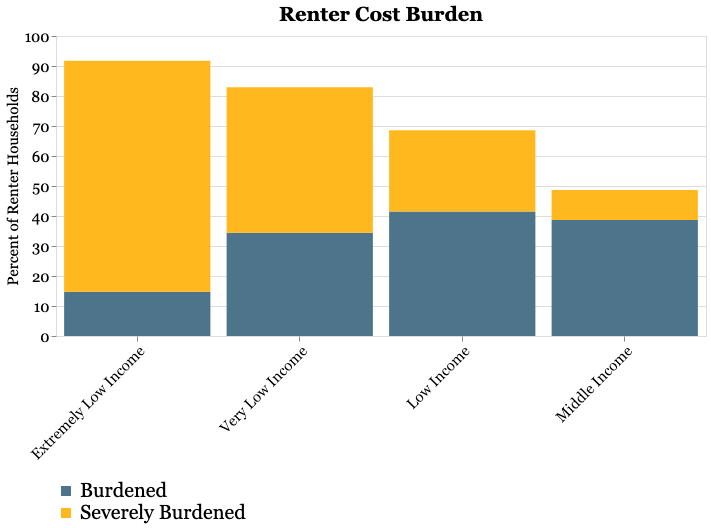

In [115]:
#Figure 3A
pivot_rent_2019 = pivot_rent_2019[pivot_rent_2019.variable != "All Incomes"]
pivot_rent_2019.replace({"Status":{"Share Burdened":"Burdened",
                                         "Share Severely Burdened":"Severely Burdened" }},inplace=True)

alt.Chart(pivot_rent_2019).mark_bar().encode(
    alt.X('variable:O',sort=["Extremely Low Income", "Very Low Income", "Low Income", "Middle Income"],title="",axis=alt.Axis( labelAngle=-45)),
    y=alt.Y('percent:Q',sort=["Burdened","Severely Burdened"],title="Percent of Renter Households", scale=alt.Scale(domain=[0, 100])),
    color=alt.Color("Status",title=None,scale=alt.Scale(domain=["Burdened","Severely Burdened"],range=["#4E748B","#FFB81D"])),
    order=alt.Order(
      'Status',
      sort='ascending'
    )).properties(
    title={
      "text": ["Renter Cost Burden"]}).configure_title(fontSize=20,anchor="middle",font="Georgia").configure_legend(direction="vertical",orient="bottom",labelLimit= 0,titleLimit=0,titleFontSize=18,
labelFontSize=20,labelFont="Georgia",titleFont="Georgia").configure_axis(domain=False,labelFont='Georgia',titleFont='Georgia',titleFontWeight="normal",labelFontSize=15,titleFontSize=15).properties(
    width=650
)


### Figure 3B

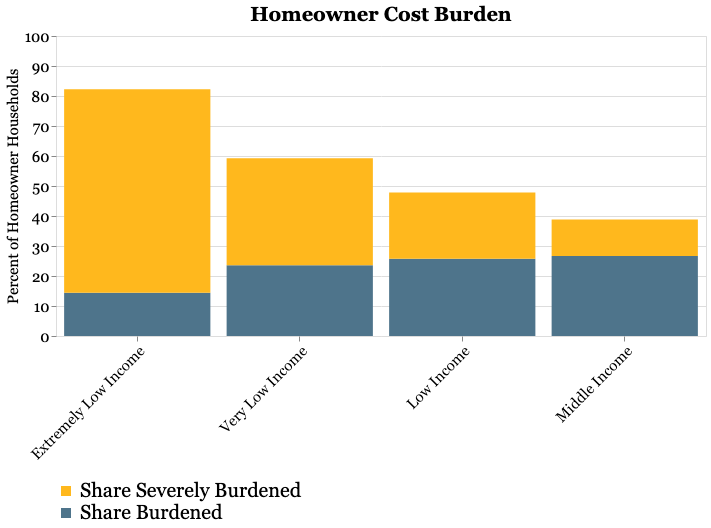

In [116]:
#Figure 3B
pivot_mortgage_2019 = pivot_mortgage_2019[pivot_mortgage_2019.variable != "All Incomes"]
pivot_mortgage_2019.replace({"Status":{"Burdened":"Cost Burdened",
"Severely Burdened":"Severely Cost Burdened" }},inplace=True)

alt.Chart(pivot_mortgage_2019).mark_bar().encode(
    alt.X('variable:O',sort=["Extremely Low Income", "Very Low Income", "Low Income", "Middle Income", "All Incomes"],title="",axis=alt.Axis( labelAngle=-45)),
    y=alt.Y('percent:Q',sort=["Severely Cost Burdened","Cost Burdened"],title="Percent of Homeowner Households", scale=alt.Scale(domain=[0, 100])),
    color=alt.Color("Status",sort=["Share Severely Burdened","Share Burdened"],title=None,scale=alt.Scale(domain=["Share Severely Burdened","Share Burdened"],range=["#FFB81D","#4E748B"])),
    order=alt.Order(
      'Status',
      sort='ascending'
    )).properties(
    title={
      "text": ["Homeowner Cost Burden"]}).configure_title(fontSize=20,anchor="middle",font="Georgia").configure_legend(direction="vertical",orient="bottom",labelLimit= 0,titleLimit=0,titleFontSize=18,
labelFontSize=20,labelFont="Georgia",titleFont="Georgia").configure_axis(domain=False,labelFont='Georgia',titleFont='Georgia',titleFontWeight="normal",labelFontSize=15,titleFontSize=15).properties(
    width=650
)

<div id="section2"></div>


# Figure 4 data prep 

In [117]:
#get individual level PUMS data (above we were using household level)
df_2019_person = check_for_PUMS_download('./psam_p06.csv',"https://www2.census.gov/programs-surveys/acs/data/pums/2019/1-Year/csv_pca.zip","./pums_2019.zip")

In [118]:
#filter for adults, relabel race data 
df_2019_person_over_18 = df_2019_person[df_2019_person.AGEP>=18]
def fix_race(race,ethnicity):
    """
    used in a lambda function to combine race and ethnicity columns in eden demographic data 
    """
    if ethnicity > 1:
        return "Hispanic"
    elif race == 1:
        return "NH White"
    elif race == 6:
        return "NH Asian"
    elif race == 2:
        return "NH Black"
    else:
        return "Other"
df_2019_person_over_18["Race_Coded"] = df_2019_person_over_18.apply(lambda x: fix_race(x.RAC1P,x.HISP),axis=1)
df_2019_person_over_18["person_id"] = np.arange

In [119]:
#here I am keeping only heads of household to mark as household race 
df_2019_person_over_18=df_2019_person_over_18[df_2019_person_over_18["RELSHIPP"] == 20]
df_2019_person_over_18 = df_2019_person_over_18[["SERIALNO","Race_Coded","WAGP"]]
#sort by serialno, wage desc, and then drop duplicates on serial no 
#household_race = df_2019_person_over_18[["SERIALNO","Race_Coded","WAGP"]].sort_values(["SERIALNO","WAGP"],ascending=False).drop_duplicates(subset="SERIALNO")

merged = df_2019.merge(df_2019_person_over_18,on="SERIALNO")

In [120]:
#make tenure verbose
merged.replace({"tenure":{1:"Owned with Mortgage",2:"Owned Free and Clear",3:"Rented",4:"Occupied without Payment of Rent"}},inplace=True)

In [121]:
#merge on AMI data, cleaned above for use in charts 3
merged_AMI = pd.merge(merged, amelti, on=['county_name', 'ppl_in_hh'], how='left')

In [122]:
#filter for 2019 
merged_AMI = merged_AMI[merged_AMI.year_y == 2019]

In [123]:
def label_ami_band(ELI30,VLI50,LI80,MED100,MOD120,hh_income):
    if hh_income <= ELI30:
        return "ELI"
    if hh_income <= VLI50:
        return "VLI"
    if hh_income <= LI80:
        return "LI"
#    if hh_income <= MED100:
#        return "MED"
    if hh_income <= MOD120:
        return "MOD"
    else:
        return "HIGH"
    
#label income bands 
merged_AMI['income_band_label'] = merged_AMI.apply(lambda x: label_ami_band(x.ELI30,x.VLI50,x.LI80,x.MED100,x.MOD120,x.hh_income), axis=1)


In [124]:
#Output csv for carolina of income band by race 
#by_county_race_ami = merged_AMI.groupby(["Race_Coded","income_band_label","tenure","county_name"]).sum().reset_index()
#overall_race_ami = merged_AMI.groupby(["Race_Coded","income_band_label","tenure"]).sum().reset_index()
#by_county_race_ami.rename(columns={"weight":"Number of Households"},inplace=True)
#by_county_race_ami.round().to_csv("race_county_AMI_tenure_count_v3.csv")
#by_county_race_ami.to_csv("race_county_AMI_tenure_count_v2.csv")
#overall_race_ami.to_csv("race_AMI_tenure_count.csv")
#overall_race_ami_renters = overall_race_ami[overall_race_ami.tenure == "Rented"]
#totals = overall_race_ami_renters.groupby("income_band_label").sum().reset_index()
#totals.rename(columns={"weight":"totals"},inplace=True)
#overall_race_ami_renters = overall_race_ami_renters.merge(totals,how="left",on="income_band_label")
#overall_race_ami_renters["percent"] = overall_race_ami_renters["weight"] /  overall_race_ami_renters["totals"]
#overall_race_ami_renters.sort_values("income_band_label").to_csv("percent_renters_by_AMI_race.csv")

In [125]:
#filter for middle income
merged_AMI = merged_AMI[["Race_Coded","weight","county_name","income_band_label","tenure","hh_income"]]
#merged_AMI['middle_income'] = np.where((merged_AMI["hh_income"] >= merged_AMI["LI80"])&(merged_AMI["hh_income"] < merged_AMI["MOD120"]), 1, 0)
merged_AMI_mid = merged_AMI[merged_AMI.income_band_label == "MOD"]
merged_AMI_mid = merged_AMI_mid.loc[:,~merged_AMI_mid.columns.duplicated()]
merged_AMI_mid = merged_AMI_mid[merged_AMI_mid.tenure != "Occupied without Payment of Rent"]
merged_AMI_mid = merged_AMI_mid[["Race_Coded","tenure","weight"]].groupby(["Race_Coded","tenure"]).sum().reset_index()
merged_AMI_mid_race_totals = merged_AMI_mid.groupby(["Race_Coded"]).sum().reset_index()
merged_AMI_mid = merged_AMI_mid.merge(merged_AMI_mid_race_totals,on="Race_Coded",how="left")
merged_AMI_mid["percentage"] = (merged_AMI_mid["weight_x"]/merged_AMI_mid["weight_y"])*100
merged_AMI_mid = merged_AMI_mid.drop(columns=["weight_x","weight_y"])
merged_AMI_mid_renter = merged_AMI_mid[merged_AMI_mid.tenure == "Rented"]
merged_AMI_mid_renter.replace({"Race_Coded":{"NH Asian":"Non-Hispanic Asian",
                                            "NH Black":"Non-Hispanic Black",
                                            "NH White":"Non-Hispanic White",
                                            "Other":"Native Hawaiian, American Indian"}},inplace=True)

<div id="section3"></div>


# Figure 4: Share of Middle-Income Renters Paying More than 30% of Income in Rent, 2010 & 2019, by Race

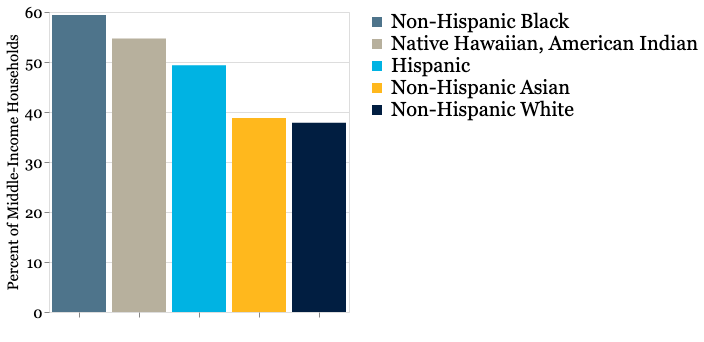

In [126]:
alt.Chart(merged_AMI_mid_renter).mark_bar().encode(
    alt.X('Race_Coded:O',title=" ",sort="-y",axis=alt.Axis( labelAngle=-45,labels=False)),
    alt.Y('percentage',title="Percent of Middle-Income Households"),
    color=alt.Color('Race_Coded:O',title="",scale=alt.Scale(domain=[
                        "Non-Hispanic Black","Native Hawaiian, American Indian","Hispanic",
                        "Non-Hispanic Asian",
                        "Non-Hispanic White",
                                        
                                
                               
                            ],range=["#4E748B",

"#B7B09D",
"#00B3E3",
"#FFB81D",
"#011E41"]))).configure_legend(direction="vertical",labelLimit= 0,titleLimit=0,titleFontSize=18,
labelFontSize=20,labelFont="Georgia",titleFont="Georgia").configure_axis(domain=False,labelFont='Georgia',titleFont='Georgia',titleFontWeight="normal",labelFontSize=15,titleFontSize=15).properties(
    width=300
)